In [1]:
!pip install -q -U watermark
!pip install -qq transformers

     |████████████████████████████████| 4.2 MB 8.6 MB/s 
     |████████████████████████████████| 86 kB 6.1 MB/s 
     |████████████████████████████████| 6.6 MB 47.9 MB/s 
     |████████████████████████████████| 596 kB 69.1 MB/s 


In [2]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.7.13
IPython version      : 5.5.0

numpy       : 1.21.6
pandas      : 1.3.5
torch       : 1.11.0+cu113
transformers: 4.19.4



In [3]:
from google.colab import drive
import pandas as pd

drive.mount('/drive')

Mounted at /drive


In [4]:
import os

os.chdir("/drive/MyDrive/inflation_reports") 
os.getcwd()

'/drive/MyDrive/inflation_reports'

In [5]:
print(os.listdir() )

['Miniconda3-py37_4.8.2-Linux-x86_64.sh.3', 'Miniconda3-py37_4.8.2-Linux-x86_64.sh.1', 'Miniconda3-py37_4.8.2-Linux-x86_64.sh', 'Miniconda3-py37_4.8.2-Linux-x86_64.sh.2', 'feb_2011.pdf', 'may_2011.pdf', 'dataset', 'mini.sh', 'best_model_state.bin', 'model.png']


In [6]:
path = "/drive/MyDrive/inflation_reports/dataset/data.csv"
df = pd.read_csv(path, encoding='latin-1')

In [7]:
df.head()

,sentiment,sentence
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [8]:
df.shape

(4846, 2)

In [9]:
# check for missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846 entries, 0 to 4845
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  4846 non-null   object
 1   sentence   4846 non-null   object
dtypes: object(2)
memory usage: 75.8+ KB


In [10]:
#@title Setup & Config
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.empty_cache()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


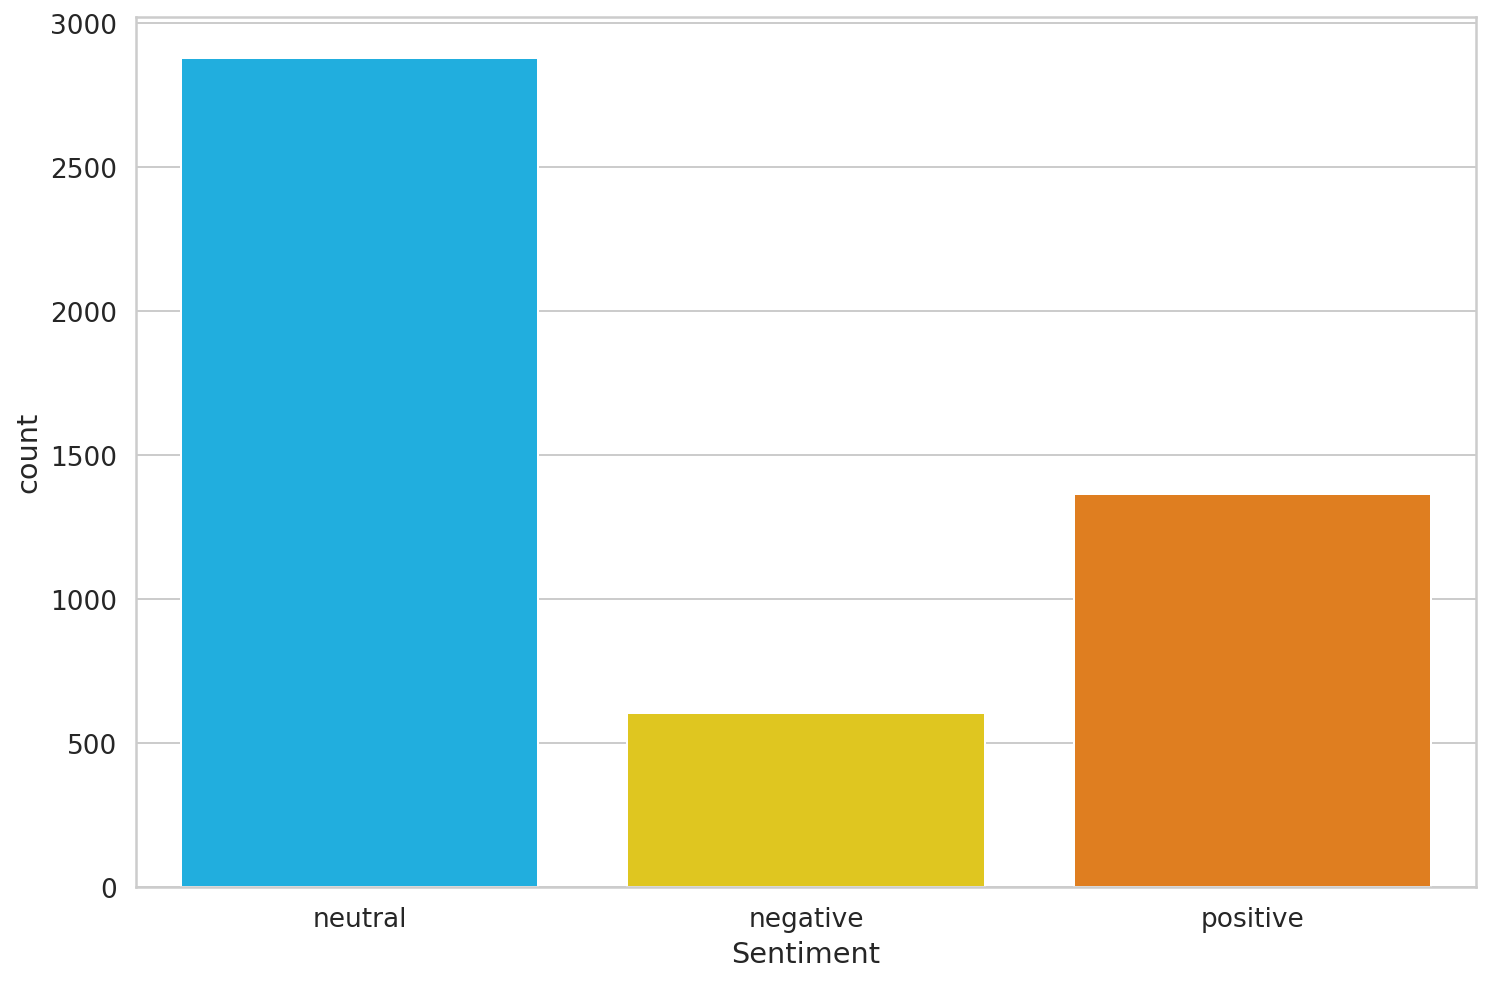

In [11]:
sns.countplot(df.sentiment)
plt.xlabel('Sentiment');

In [12]:
def to_sentiment(rating):

  if rating == 'negative':
    return 0
  elif rating == 'neutral':
    return 1
  elif rating == 'positive':
    return 2

df['score'] = df.sentiment.apply(to_sentiment)

In [13]:
PRE_TRAINED_MODEL_NAME = 'ProsusAI/finbert'
#PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [14]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict = False) 

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/252 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/758 [00:00<?, ?B/s]

In [15]:
token_lens = []
print(df.sentence)

#store the token length of each sentence
# word to vec
for txt in df.sentence:
  tokens = tokenizer.encode(txt, max_length=512) 
  token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


0       According to Gran , the company has no plans t...
1       Technopolis plans to develop in stages an area...
2       The international electronic industry company ...
3       With the new production plant the company woul...
4       According to the company 's updated strategy f...
                              ...                        
4841    LONDON MarketWatch -- Share prices ended lower...
4842    Rinkuskiai 's beer sales fell by 6.5 per cent ...
4843    Operating profit fell to EUR 35.4 mn from EUR ...
4844    Net sales of the Paper segment decreased to EU...
4845    Sales in Finland decreased by 10.5 % in Januar...
Name: sentence, Length: 4846, dtype: object


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


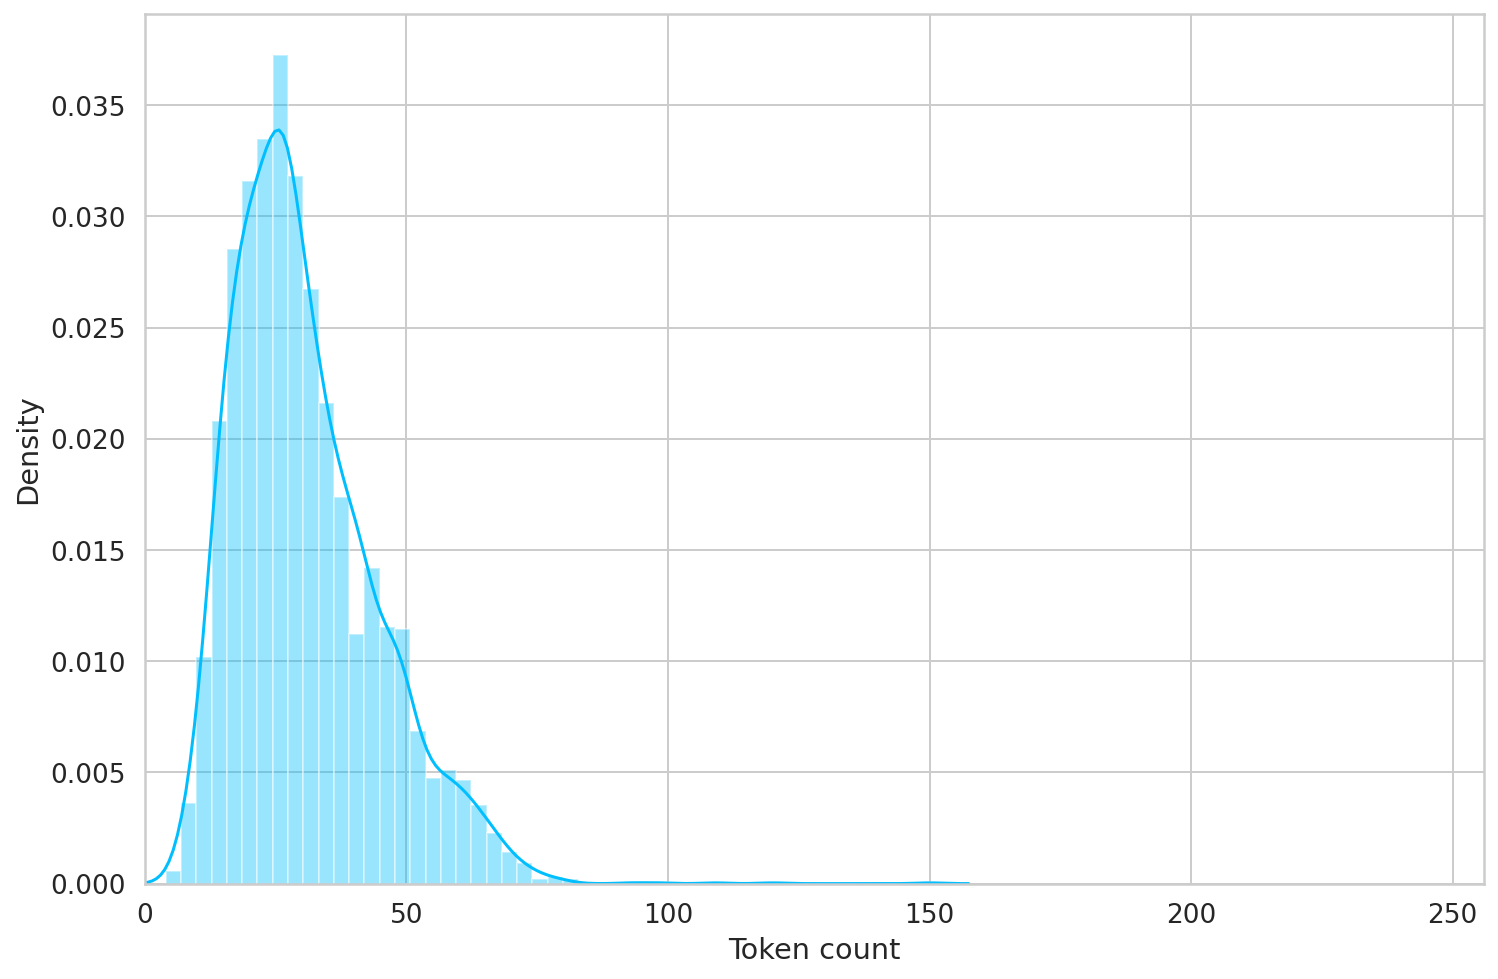

In [16]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [17]:
MAX_LEN = 160

In [18]:
class GPReviewDataset(Dataset):

  def __init__(self, sentences, labels, tokenizer, max_len):
    self.sentences = sentences
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.sentences)
  
  def __getitem__(self, item):
    sentence = str(self.sentences[item])
    label = self.labels[item]

    encoding = self.tokenizer.encode_plus(
      sentence,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding = 'max_length',
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'financiar_text': sentence,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'label': torch.tensor(label, dtype=torch.long)
    }

In [19]:
# split the data
df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

df_train.shape, df_val.shape, df_test.shape

((3876, 3), (485, 3), (485, 3))

In [20]:
# create data loaders
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    sentences=df.sentence.to_numpy(),
    labels=df.score.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )


  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [21]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [22]:
data = next(iter(train_data_loader))
data.keys()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


dict_keys(['financiar_text', 'input_ids', 'attention_mask', 'label'])

In [23]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['label'].shape)

torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


In [24]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict = False)

for param in bert_model.parameters():
    param.requires_grad = False

Downloading:   0%|          | 0.00/418M [00:00<?, ?B/s]

Some weights of the model checkpoint at ProsusAI/finbert were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [25]:
#create a classifier that uses the BERT model
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict = False)
    for param in self.bert.parameters():
        param.requires_grad = False
    print(self.bert.config.hidden_size);
    self.classifier = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size, 1024), 
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 128), # set not trainable
            nn.ReLU(),
            nn.Linear(128, 3)
        )

  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    #print(attention_mask,input_ids)
    return self.classifier(pooled_output)

In [26]:
class_names = ['negative', 'neutral', 'positive']
# create an instance and move it to the GPU
model = SentimentClassifier(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at ProsusAI/finbert were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


768


In [27]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 160])
torch.Size([16, 160])


In [28]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.3399, 0.3086, 0.3515],
        [0.3409, 0.3017, 0.3574],
        [0.3243, 0.3183, 0.3575],
        [0.3661, 0.2990, 0.3350],
        [0.3446, 0.3173, 0.3381],
        [0.3434, 0.3145, 0.3421],
        [0.3508, 0.3001, 0.3491],
        [0.3481, 0.3050, 0.3469],
        [0.3415, 0.2935, 0.3650],
        [0.3689, 0.2898, 0.3413],
        [0.3496, 0.3016, 0.3488],
        [0.3290, 0.3067, 0.3643],
        [0.3686, 0.3119, 0.3195],
        [0.3313, 0.2907, 0.3779],
        [0.3514, 0.3124, 0.3362],
        [0.3538, 0.2934, 0.3528]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [29]:
# Training

# BERT recommendations for fine-tuning:

# Batch size: 16, 32
# Learning rate (Adam): 5e-5, 3e-5, 2e-5
# Number of epochs: 2, 3, 4

# increasing the batch size reduces the training time significantly, but gives you lower accuracy

EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [30]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    labels = d["label"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, labels)

    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [31]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      labels = d["label"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, labels)

      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [32]:
!pip install torch-summary

from torchsummary import summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [33]:
# print network summary
summary(model,input_size=(768,),depth=5,batch_dim=1, dtypes=['torch.IntTensor'])

Layer (type:depth-idx)                                  Param #
├─BertModel: 1-1                                        --
|    └─BertEmbeddings: 2-1                              --
|    |    └─Embedding: 3-1                              (23,440,896)
|    |    └─Embedding: 3-2                              (393,216)
|    |    └─Embedding: 3-3                              (1,536)
|    |    └─LayerNorm: 3-4                              (1,536)
|    |    └─Dropout: 3-5                                --
|    └─BertEncoder: 2-2                                 --
|    |    └─ModuleList: 3-6                             --
|    |    |    └─BertLayer: 4-1                         --
|    |    |    |    └─BertAttention: 5-1                (2,363,904)
|    |    |    |    └─BertIntermediate: 5-2             (2,362,368)
|    |    |    |    └─BertOutput: 5-3                   (2,361,600)
|    |    |    └─BertLayer: 4-2                         --
|    |    |    |    └─BertAttention: 5-4                

Layer (type:depth-idx)                                  Param #
├─BertModel: 1-1                                        --
|    └─BertEmbeddings: 2-1                              --
|    |    └─Embedding: 3-1                              (23,440,896)
|    |    └─Embedding: 3-2                              (393,216)
|    |    └─Embedding: 3-3                              (1,536)
|    |    └─LayerNorm: 3-4                              (1,536)
|    |    └─Dropout: 3-5                                --
|    └─BertEncoder: 2-2                                 --
|    |    └─ModuleList: 3-6                             --
|    |    |    └─BertLayer: 4-1                         --
|    |    |    |    └─BertAttention: 5-1                (2,363,904)
|    |    |    |    └─BertIntermediate: 5-2             (2,362,368)
|    |    |    |    └─BertOutput: 5-3                   (2,361,600)
|    |    |    └─BertLayer: 4-2                         --
|    |    |    |    └─BertAttention: 5-4                

In [34]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  print(train_data_loader)
  
  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss.item())
  history['val_acc'].append(val_acc.item())
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 0.30582160962584576 accuracy 0.8924148606811145
Val   loss 0.26911572787550186 accuracy 0.9010309278350516

Epoch 2/10
----------
Train loss 0.27133620666041053 accuracy 0.8970588235294117
Val   loss 0.26366136475436147 accuracy 0.9010309278350516

Epoch 3/10
----------
Train loss 0.27400142911039754 accuracy 0.8949948400412796
Val   loss 0.2560862498658319 accuracy 0.9030927835051547

Epoch 4/10
----------
Train loss 0.26829588296727386 accuracy 0.8962848297213621
Val   loss 0.2554021028261031 accuracy 0.9051546391752577

Epoch 5/10
----------
Train loss 0.2624417592315272 accuracy 0.9001547987616099
Val   loss 0.25648138515891566 accuracy 0.9051546391752577

Epoch 6/10
----------
Train loss 0.26742638019009385 accuracy 0.8975748194014447
Val   loss 0.2534135395000058 accuracy 0.9072164948453608

Epoch 7/10
----------
Train loss 0.2648907198106924 accuracy 0.8970588235294117
Val   loss 0.2523358110939303 accuracy 0.9072164948453608

Epoch 8/10
----------
Train loss 0.269498

[tensor(0.8924, device='cuda:0', dtype=torch.float64), tensor(0.8971, device='cuda:0', dtype=torch.float64), tensor(0.8950, device='cuda:0', dtype=torch.float64), tensor(0.8963, device='cuda:0', dtype=torch.float64), tensor(0.9002, device='cuda:0', dtype=torch.float64), tensor(0.8976, device='cuda:0', dtype=torch.float64), tensor(0.8971, device='cuda:0', dtype=torch.float64), tensor(0.8963, device='cuda:0', dtype=torch.float64), tensor(0.8981, device='cuda:0', dtype=torch.float64), tensor(0.8991, device='cuda:0', dtype=torch.float64)]
[0.9010309278350516, 0.9010309278350516, 0.9030927835051547, 0.9051546391752577, 0.9051546391752577, 0.9072164948453608, 0.9072164948453608, 0.9051546391752577, 0.9072164948453608, 0.9030927835051547]
tensor([0.8924, 0.8971, 0.8950, 0.8963, 0.9002, 0.8976, 0.8971, 0.8963, 0.8981,
        0.8991], dtype=torch.float64)


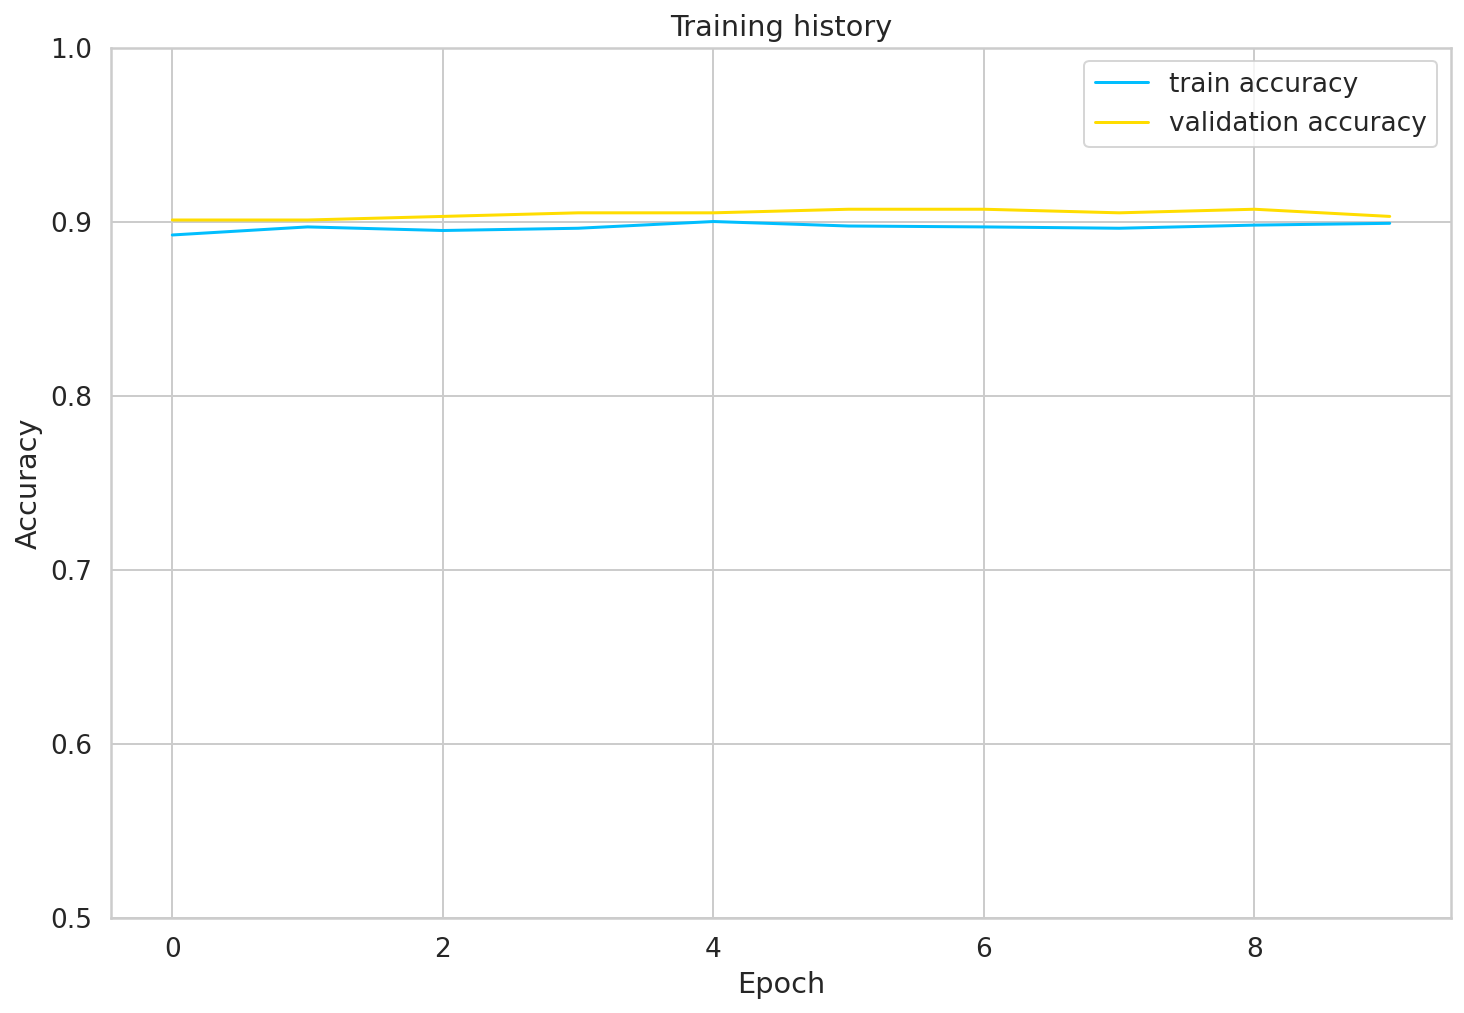

In [35]:
print(history['train_acc'])
print(history['val_acc'])

new_tensor = torch.tensor(history['train_acc'], device = 'cpu')
print(new_tensor)

plt.plot(new_tensor, label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.5, 1]);

In [36]:
# calculating the accuracy on the test data
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


0.9072164948453608

In [37]:
# This is similar to the evaluation function, 
# except that we're storing the text and the predicted probabilities 
# (by applying the softmax on the model outputs)

def get_predictions(model, data_loader):
  model = model.eval()
  
  financiar_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["financiar_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["label"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      financiar_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return financiar_texts, predictions, prediction_probs, real_values

In [38]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [39]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.92      0.96      0.94        56
     neutral       0.94      0.90      0.92       285
    positive       0.84      0.90      0.87       144

    accuracy                           0.91       485
   macro avg       0.90      0.92      0.91       485
weighted avg       0.91      0.91      0.91       485



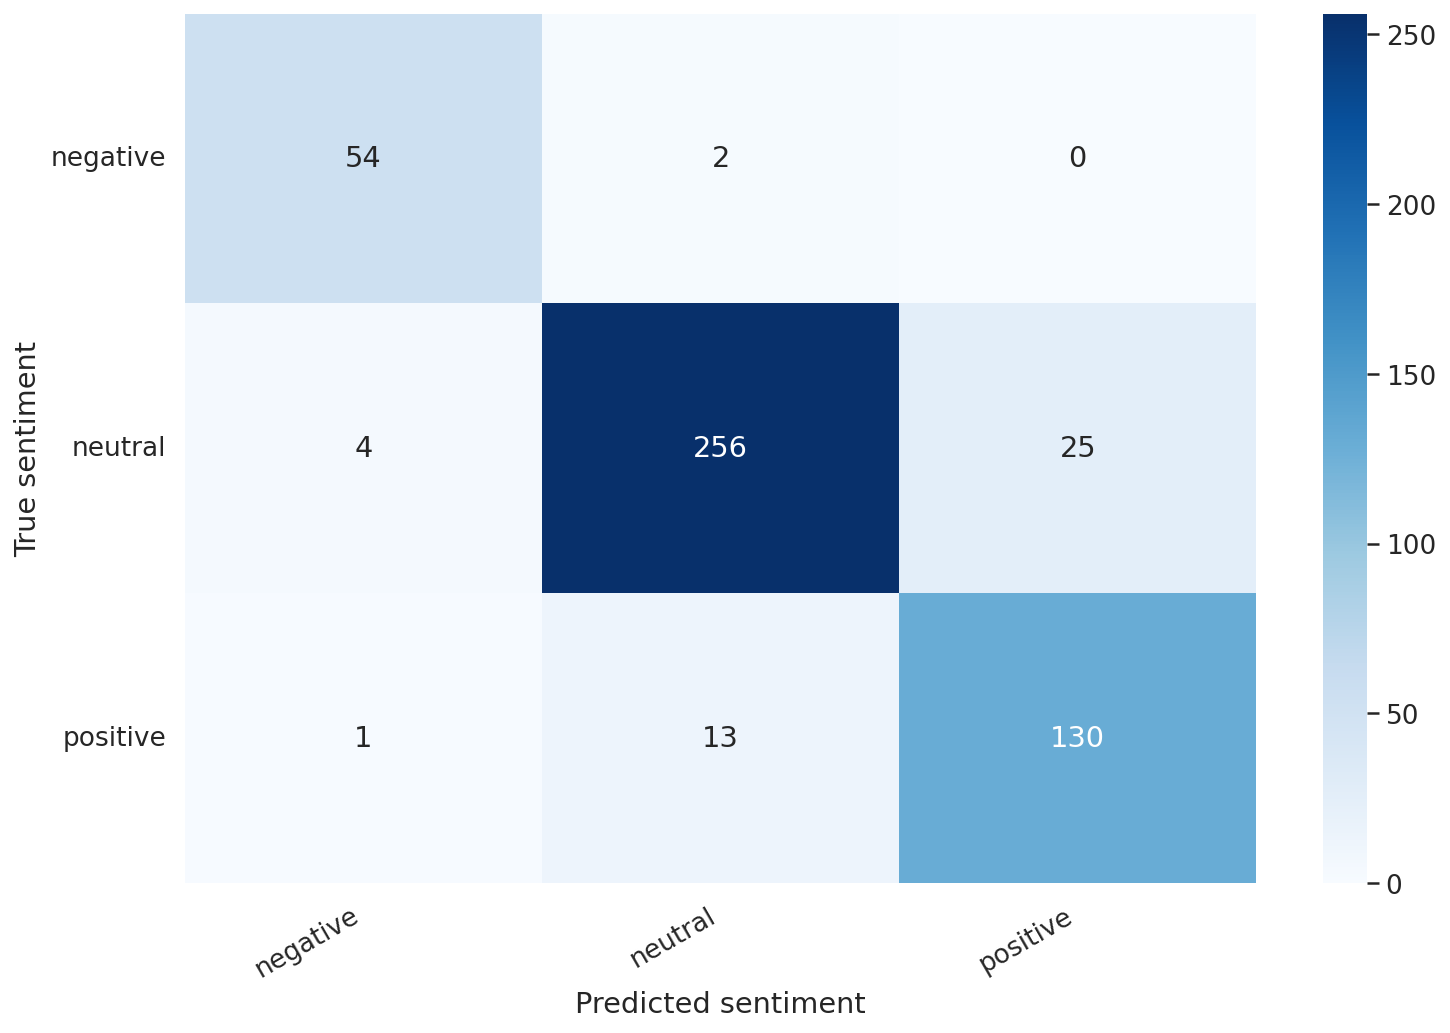

In [40]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [41]:
idx = 2

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [42]:
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

As the world leaders in developing UV technology for municipal
wastewater , drinking water , and industrial water treatment systems ,
Trojan Technologies was a logical partner in providing W+Ærtsil+Æ with
UV technology for ballast water treatment .

True sentiment: neutral


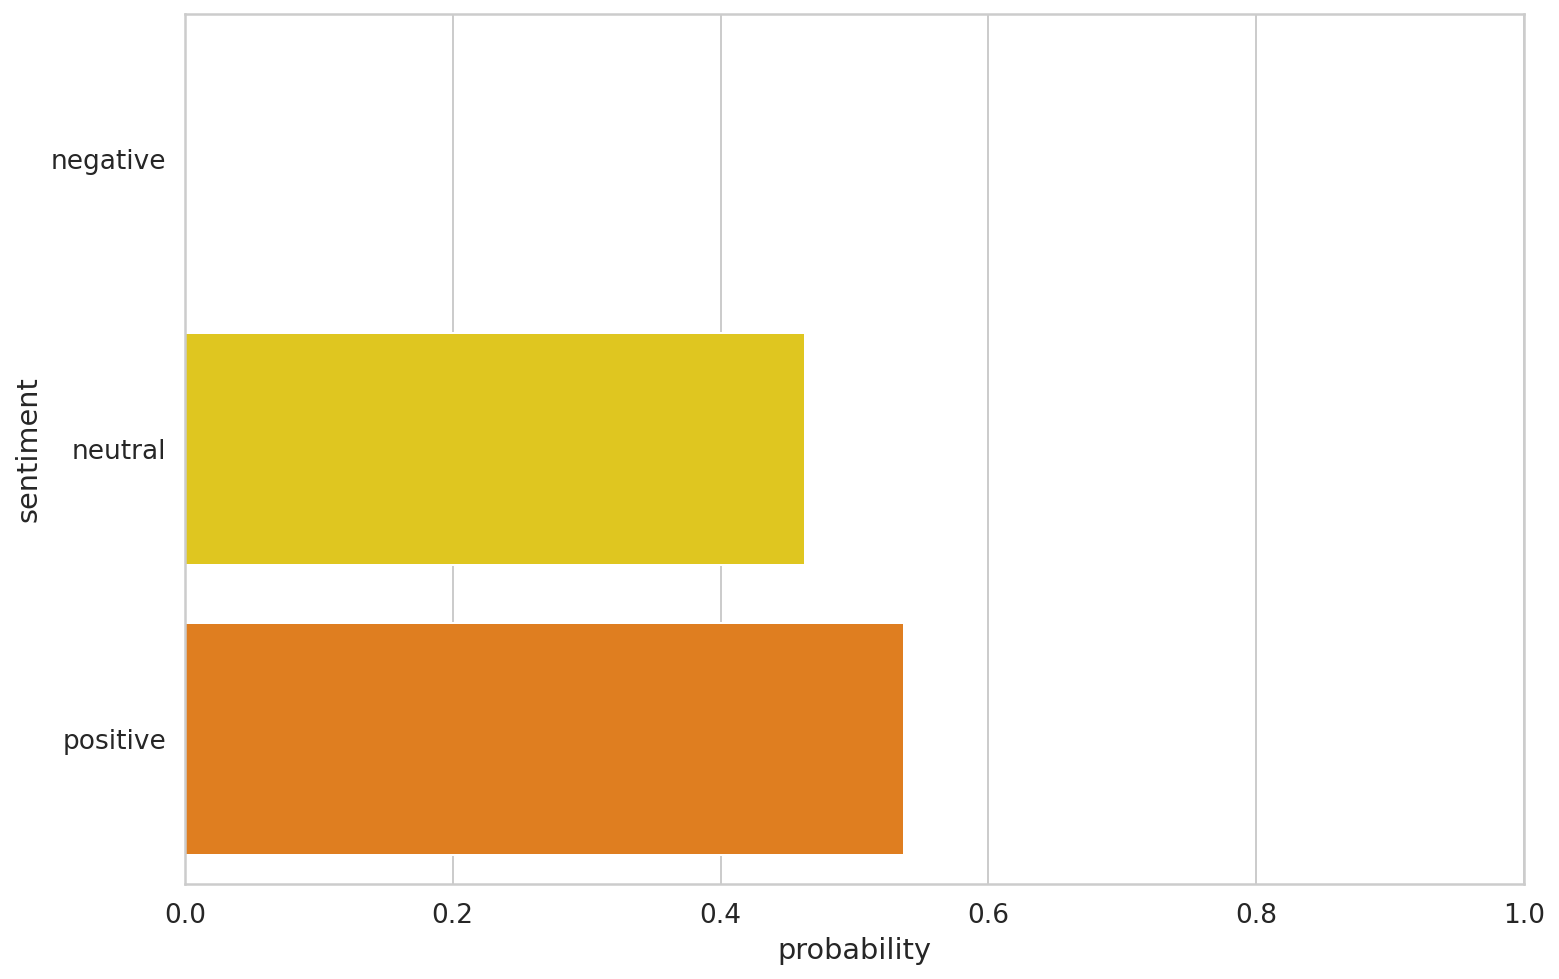

In [43]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

In [44]:
review_text = "In March 2011, the annual CPI inflation rate stood at 8.01 percent, 0.05 percentage points above the level seen in December 2010 and 1.2 percentage points above that forecasted in the February 2011 Inflation Report. The major factor which prevented inflation from declining in 2011 Q1, as envisaged in the baseline scenario presented in the previous Inflation Report, was that some of the significant risks mentioned in that Report materialised. Specifically, substantial increases in international food and fuel prices were recorded, which fed through to domestic consumer prices."

In [45]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  padding = 'max_length',
  return_attention_mask=True,
  return_tensors='pt',
)

In [46]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: In March 2011, the annual CPI inflation rate stood at 8.01 percent, 0.05 percentage points above the level seen in December 2010 and 1.2 percentage points above that forecasted in the February 2011 Inflation Report. The major factor which prevented inflation from declining in 2011 Q1, as envisaged in the baseline scenario presented in the previous Inflation Report, was that some of the significant risks mentioned in that Report materialised. Specifically, substantial increases in international food and fuel prices were recorded, which fed through to domestic consumer prices.
Sentiment  : neutral
